Copyright 2024, pre63

License: MIT, see https://opensource.org/licenses/MIT

# ActorCritic Mountain Car Hyperparameter Tuning with Tile Coding

This notebook I investigate the application of the ActorCritic algorithm with tile coding on the OpenAI Gym’s mountain car problem. I aimed to identify the optimal hyperparameters and implemented an adaptive method for adjusting the exploration parameter, $\epsilon$, as the learning progresses. Our results indicate that carefully selected learning parameters, combined with a strategically decaying exploration rate, considerably enhance the algorithm's performance in this complex environment.

## Introduction
The mountain car scenario involves a simulated car that must be driven up a steep hill, necessitating backward movement to gain enough momentum to reach the goal. This environment is particularly suited for examining reinforcement learning algorithms due to its clear episodic structure and the necessity for significant exploration to discover a successful strategy.
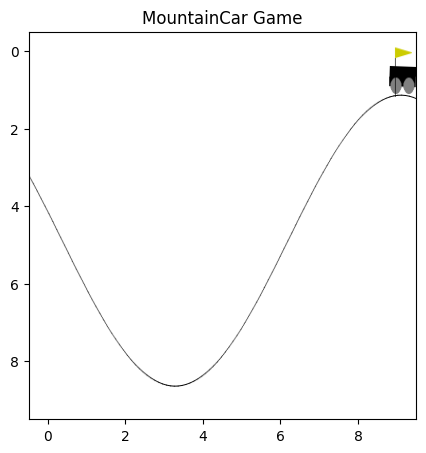



In [37]:
import os
os.environ["WANDB_API_KEY"] = ""

In [38]:
%matplotlib inline

In [39]:
# Standard library imports
import itertools
import random
import time
from collections import deque, namedtuple
import copy

# Third-party imports
import gym
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import display, clear_output
from torch.distributions import Categorical
import wandb


import numpy as np
from numpy import Inf, inf


In [47]:
# Base Model Classes

class RunModel:
    def infer_action(state):
        pass

    def step(self, action):
        pass

    def render(self):
        pass

    def close(self):
        pass
    
    def init_run(self):
        pass
    
    def run(self, max_steps=1000):
        state, _ = self.env.reset()
        total_reward = 0
        step_count = 0

        for i in range(max_steps):
            action = self.infer_action(state)
            next_state, reward, done, truncated, _ = self.step(action)

            state = next_state
            total_reward += reward

            step_count += 1

            if i % 10 == 0:
              self.render()

            if done:
                self.render()
                break

        self.close()


class LogModel:
    def setup(self, config):
        wandb.init(project="Sarsa Montain Car Tuning", config=config)
        wandb.run.name = self.label

    def log(self, info):
        wandb.log(info)

    def finish(self):
        wandb.finish()


class Model(RunModel, LogModel):
    def __init__(self, display=True):
        self.label = self.__class__.__name__

In [40]:
# Replay Buffer Implementation

# Copyright (c) 2024, Cheng Xiaotian
# https://github.com/greatwallet/mountain-car/blob/master/Replay_Buffer.py

class Replay_Buffer(object):
    """Replay buffer to store past experiences that the agent can then use for training data"""
    
    def __init__(self, buffer_size, batch_size, seed):

        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add_experience(self, states, actions, rewards, next_states, dones):
        """Adds experience(s) into the replay buffer"""
        if isinstance(dones, list):
            if isinstance(dones[0], list):
                raise ValueError("A done shouldn't be a list")
            # assert type(dones[0]) != list, "A done shouldn't be a list"
            experiences = [self.experience(state, action, reward, next_state, done)
                           for state, action, reward, next_state, done in
                           zip(states, actions, rewards, next_states, dones)]
            self.memory.extend(experiences)
        else:
            experience = self.experience(states, actions, rewards, next_states, dones)
            self.memory.append(experience)
   
    def sample(self, num_experiences=None, separate_out_data_types=True):
        """Draws a random sample of experience from the replay buffer"""
        experiences = self.pick_experiences(num_experiences)
        if separate_out_data_types:
            states, actions, rewards, next_states, dones = self.separate_out_data_types(experiences)
            return states, actions, rewards, next_states, dones
        else:
            return experiences
            
    def separate_out_data_types(self, experiences):
        """Puts the sampled experience into the correct format"""
        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None])
        rewards = np.vstack([e.reward for e in experiences if e is not None])
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = np.array([int(e.done) for e in experiences if e is not None]).astype(np.float32)
        
        return states, actions, rewards, next_states, dones
    
    def pick_experiences(self, num_experiences=None):
        if num_experiences is not None: batch_size = num_experiences
        else: batch_size = self.batch_size
        return random.sample(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

In [41]:
# ActorCritic Model Implementation

# Copyright (c) 2024, Cheng Xiaotian
# https://github.com/greatwallet/mountain-car/blob/master/DDPG.py

class Actor(nn.Module):
    def __init__(self, n_states):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states, 20), 
            nn.ReLU(), 
            nn.Linear(20, 20), 
            nn.ReLU(), 
            nn.Linear(20, 20), 
            nn.ReLU(), 
            nn.Linear(20, 1)
        )
        
    def forward(self, state):
        return self.net(state)

class Critic(nn.Module):
    def __init__(self, n_states, n_actions):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states + n_actions, 20), 
            nn.ReLU(), 
            nn.Linear(20, 20), 
            nn.ReLU(), 
            nn.Linear(20, 20), 
            nn.ReLU(), 
            nn.Linear(20, n_actions)
        )
        
    def forward(self, state, action):
        return self.net(torch.cat((state, action), 1))



In [42]:
# Ornstein-Uhlenbeck Noise Class

# Copyright (c) 2024, Cheng Xiaotian
# https://github.com/greatwallet/mountain-car/blob/master/OU_Noise.py

class OU_Noise(object):
    """Ornstein-Uhlenbeck process."""
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        dx = self.theta * (self.mu - self.state) + self.sigma * np.array([np.random.normal() for _ in range(len(self.state))])
        self.state += dx
        return self.state

In [43]:
# ActorCritic Agent Class

# Based on the work of Cheng Xiaotian
# https://github.com/greatwallet/mountain-car/blob/master/train_continuous.py

class Agent(Model):
    def __init__(self, 
                 env,
                 seed=0,
                 buffer_size=1000000,
                 batch_size=256,
                 mem_seed=17,
                 ou_seed=41,
                 lr_critic=2e-2,
                 lr_actor=3e-3,
                 episodes=450,
                 update_every_n_steps=20,
                 learning_updates_per_learning_session=10,
                 mu=0.0,
                 theta=0.15,
                 sigma=0.25,
                 gamma=0.99,
                 clamp_critic=5,
                 clamp_actor=5,
                 tau_critic=5e-3,
                 tau_actor=5e-3,
                 win=100,
                 score_th=90):

        self.label = f"Agent(αc%.5f_αc%.5f_γ%.5f_e%d)" % (
            lr_critic, lr_actor, gamma, episodes)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.env = env
        self.seed = seed
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.mem_seed = mem_seed
        self.ou_seed = ou_seed
        self.lr_critic = lr_critic
        self.lr_actor = lr_actor
        self.episodes = episodes
        self.update_every_n_steps = update_every_n_steps
        self.learning_updates_per_learning_session = learning_updates_per_learning_session
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.gamma = gamma
        self.clamp_critic = clamp_critic
        self.clamp_actor = clamp_actor
        self.tau_critic = tau_critic
        self.tau_actor = tau_actor
        self.win = win
        self.score_th = score_th

        self.memory = Replay_Buffer(buffer_size, batch_size, seed)

        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.shape[0]

        # critic
        self.critic_local = Critic(self.n_states, self.n_actions).to(self.device)
        self.critic_target = Critic(self.n_states, self.n_actions).to(self.device)
        self.model_deep_copy(from_model=self.critic_local, to_model=self.critic_target)

        self.optim_critic = optim.Adam(
            self.critic_local.parameters(), lr=lr_critic, eps=1e-4)

        self.memory = Replay_Buffer(buffer_size, batch_size, mem_seed)

        # actor
        self.actor_local = Actor(self.n_states).to(self.device)
        self.actor_target = Actor(self.n_states).to(self.device)
        self.model_deep_copy(from_model=self.actor_local, to_model=self.actor_target)

        self.optim_actor = optim.Adam(
            self.actor_local.parameters(), lr=lr_actor, eps=1e-4)

        # ou noise
        self.ou_noise = OU_Noise(
            size=self.n_actions,
            seed=ou_seed,
            mu=mu,
            theta=theta,
            sigma=sigma
        )

        self.rewards = []
        self.steps = []

    def decay(starting_lr, optimizer, rolling_score_list, score_th):
        """Lowers the learning rate according to how close we are to the solution"""
        if len(rolling_score_list) > 0:
            last_rolling_score = rolling_score_list[-1]
            if last_rolling_score > 0.75 * score_th:
                new_lr = starting_lr / 100.0
            elif last_rolling_score > 0.6 * score_th:
                new_lr = starting_lr / 20.0
            elif last_rolling_score > 0.5 * score_th:
                new_lr = starting_lr / 10.0
            elif last_rolling_score > 0.25 * score_th:
                new_lr = starting_lr / 2.0
            else:
                new_lr = starting_lr
            for g in optimizer.param_groups:
                g['lr'] = new_lr

    def model_deep_copy(self, from_model, to_model):
        """Copies model parameters from from_model to to_model"""
        for to_model, from_model in zip(to_model.parameters(), from_model.parameters()):
            to_model.data.copy_(from_model.data.clone())

    def train(self):
        self.ou_noise.reset()

        global_step_idx = 0
        score_list = []
        rolling_score_list = []
        max_score = float('-inf')
        max_rolling_score = float('-inf')

        for i_episode in range(self.episodes):
            start = time.time()
            state_numpy, info = env.reset()
            next_state_numpy = None
            action_numpy = None
            reward = None
            done = False
            score = 0
            steps = 0

            while not done:
                steps += 1
                # pick an action
                state = torch.from_numpy(
                    state_numpy).float().unsqueeze(0).to(self.device)
                self.actor_local.eval()
                with torch.no_grad():
                    action_numpy = self.actor_local(
                        state).cpu().data.numpy().squeeze(0)
                self.actor_local.train()
                
                # perturb as action
                action_numpy += self.ou_noise.sample()

                # conduct action
                next_state_numpy, reward, done, truncated, _ = env.step(
                    action_numpy)
                score += reward

                # time for training and updating
                if len(self.memory) > self.batch_size and global_step_idx % self.update_every_n_steps == 0:
                    for _ in range(self.learning_updates_per_learning_session):
                        # sample experience (`tensor`)
                        states_numpy, actions_numpy, rewards_numpy, next_states_numpy, dones_numpy = self.memory.sample()
                        states = torch.from_numpy(
                            states_numpy).float().to(self.device)
                        actions = torch.from_numpy(
                            actions_numpy).float().to(self.device)
                        rewards = torch.from_numpy(
                            rewards_numpy).float().to(self.device)
                        next_states = torch.from_numpy(
                            next_states_numpy).float().to(self.device)
                        dones = torch.from_numpy(
                            dones_numpy).float().unsqueeze(1).to(self.device)
                     
                        # 1. critic update
                        # 1.1 compute loss
                        # 1.1.1 compute target
                        with torch.no_grad():
                            next_actions = self.actor_target(next_states)
                            next_value = self.critic_target(
                                next_states, next_actions)
                            value_target = rewards + self.gamma * \
                                next_value * (1.0 - dones)

                        # 1.1.2. compute expected
                        value = self.critic_local(states, actions)
                    
                        # 1.1.3 compute loss
                        loss_critic = F.mse_loss(value, value_target)
                    
                        # 1.2 optimization
                        self.optim_critic.zero_grad()
                        loss_critic.backward()

                        if self.clamp_critic is not None:
                            torch.nn.utils.clip_grad_norm_(
                                self.critic_local.parameters(),
                                self.clamp_critic
                            )
                        self.optim_critic.step()
                      
                        # 1.3 soft update
                        for target_param, local_param in zip(self.critic_target.parameters(), self.critic_local.parameters()):
                            target_param.data.copy_(
                                self.tau_critic * local_param.data + (1.0 - self.tau_critic) * target_param.data)

                        # 2. actor update
                        # 2.1. update learning rate
                        if done:
                            try:
                              self.decay(
                                  starting_lr=self.lr_actor,
                                  optimizer=self.optim_actor,
                                  rolling_score_list=rolling_score_list,
                                  score_th=self.score_th
                              )
                            except:
                                pass

                        # 2.2.compute loss
                        pred_actions = self.actor_local(states)
                        loss_actor = -self.critic_local(states, pred_actions).mean()

                        # 2.3. optimization
                        self.optim_actor.zero_grad()
                        loss_actor.backward()

                        if self.clamp_actor is not None:
                            torch.nn.utils.clip_grad_norm_(
                                self.actor_local.parameters(),
                                self.clamp_actor
                            )
                       
                        # 2.4. soft update
                        for target_param, local_param in zip(self.actor_target.parameters(), self.actor_local.parameters()):
                            target_param.data.copy_(
                                self.tau_critic * local_param.data + (1.0 - self.tau_critic) * target_param.data)

                # save experience
                self.memory.add_experience(
                    state_numpy, action_numpy, reward, next_state_numpy, done)
                state_numpy = next_state_numpy
                global_step_idx += 1

            self.steps.append(steps)
            self.rewards.append(score)

            # save and print results
            score_list.append(score)
            rolling_score = np.mean(score_list[-1 * self.win:])
            rolling_score_list.append(rolling_score)
            if score > max_score:
                max_score = score
            if rolling_score > max_rolling_score:
                max_rolling_score = rolling_score

            end = time.time()
            print("[Episode {:4d}: score: {}; rolling score: {}, max score: {}, max rolling score: {}, time cost: {:.2f}]".format(
                i_episode, score, rolling_score, max_score, max_rolling_score, end - start))


    def run(self):
        # Create figure for plotting
        self.fig, ax = plt.subplots(1, 1, figsize=(5, 8))
        self.image = ax.imshow(np.random.rand(10, 10), cmap='gray')
        ax.set_title('MountainCar Game')

        super().run()

    def step(self, action):
        return self.env.step(action)

    def render(self):
        new_image_data = self.env.render()
        self.image.set_data(new_image_data)
        self.image.autoscale()
        clear_output(wait=True)
        display(self.fig)

    def infer_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        
        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy().squeeze(0)

        self.actor_local.train()
        
        return action

    def close(self):
        self.env.close()


In [44]:
env = gym.make("MountainCarContinuous-v0", render_mode='rgb_array')

In [45]:
agenta = Agent(env, lr_critic=2e-3, lr_actor=3e-4, gamma=.99, episodes=10)
agenta.train()

[Episode    0: score: 59.065303284564564; rolling score: 59.065303284564564, max score: 59.065303284564564, max rolling score: 59.065303284564564, time cost: 9.76]
[Episode    1: score: 80.34271777297374; rolling score: 69.70401052876915, max score: 80.34271777297374, max rolling score: 69.70401052876915, time cost: 5.35]
[Episode    2: score: 44.27226181664623; rolling score: 61.226760958061504, max score: 80.34271777297374, max rolling score: 69.70401052876915, time cost: 13.03]
[Episode    3: score: 82.05726732302244; rolling score: 66.43438754930173, max score: 82.05726732302244, max rolling score: 69.70401052876915, time cost: 4.36]
[Episode    4: score: 80.59664068018405; rolling score: 69.2668381754782, max score: 82.05726732302244, max rolling score: 69.70401052876915, time cost: 4.67]
[Episode    5: score: 77.59168280777611; rolling score: 70.65431228086119, max score: 82.05726732302244, max rolling score: 70.65431228086119, time cost: 6.35]
[Episode    6: score: 66.5333943389

In [46]:
agentb = Agent(env, lr_critic=2e-1, lr_actor=3e-2, gamma=.99, episodes=10)
agentb.train()

[Episode    0: score: 25.146236906639842; rolling score: 25.146236906639842, max score: 25.146236906639842, max rolling score: 25.146236906639842, time cost: 14.45]
[Episode    1: score: 82.36429774082853; rolling score: 53.75526732373419, max score: 82.36429774082853, max rolling score: 53.75526732373419, time cost: 3.81]
[Episode    2: score: 45.29099017660394; rolling score: 50.9338416080241, max score: 82.36429774082853, max rolling score: 53.75526732373419, time cost: 12.84]
[Episode    3: score: 62.00631630411419; rolling score: 53.70196028204663, max score: 82.36429774082853, max rolling score: 53.75526732373419, time cost: 9.07]
[Episode    4: score: 87.37672726514212; rolling score: 60.436913678665725, max score: 87.37672726514212, max rolling score: 60.436913678665725, time cost: 2.08]
[Episode    5: score: 90.09057314617382; rolling score: 65.37919025658374, max score: 90.09057314617382, max rolling score: 65.37919025658374, time cost: 1.93]
[Episode    6: score: -67.2839736

In [48]:
agentc = Agent(env, lr_critic=2e-2, lr_actor=3e-3, gamma=.99, episodes=10)
agentc.train()

[Episode    0: score: 70.03659710111333; rolling score: 70.03659710111333, max score: 70.03659710111333, max rolling score: 70.03659710111333, time cost: 4.85]
[Episode    1: score: 73.25234919930476; rolling score: 71.64447315020905, max score: 73.25234919930476, max rolling score: 71.64447315020905, time cost: 6.44]
[Episode    2: score: 85.58762855988887; rolling score: 76.29219162010232, max score: 85.58762855988887, max rolling score: 76.29219162010232, time cost: 3.28]
[Episode    3: score: 10.553088868482973; rolling score: 59.85741593219748, max score: 85.58762855988887, max rolling score: 76.29219162010232, time cost: 23.96]
[Episode    4: score: 82.27564453291157; rolling score: 64.3410616523403, max score: 85.58762855988887, max rolling score: 76.29219162010232, time cost: 4.04]
[Episode    5: score: 77.77528124687528; rolling score: 66.58009825142946, max score: 85.58762855988887, max rolling score: 76.29219162010232, time cost: 5.40]
[Episode    6: score: 81.95445571001488

In [49]:
# Model Comparison

class ModelComparator:
    def __init__(self, models):
        self.models = models

    def safe_statistics(self, data):
        if data:
            return np.mean(data), np.min(data), np.max(data)
        else:
            return (np.nan, np.nan, np.nan)

    def report(self):
        line_styles = ['-', '--', '-.', ':']
        markers = ['o', 's', '^', 'd', '*', 'p', 'h', 'x']
        colors = itertools.cycle(plt.cm.tab10.colors)
        line_cycle = itertools.cycle(line_styles)
        marker_cycle = itertools.cycle(markers)

        fig_width = max(15, len(self.models) * 2)
        fig, axs = plt.subplots(3, figsize=(fig_width, 20), gridspec_kw={
                                'height_ratios': [1, 1, 0.5]})
        fig.suptitle('Model Performance Comparison')

        summary_data = []

        for model in self.models:
            label = model.label
            color = next(colors)
            line_style = next(line_cycle)
            marker = next(marker_cycle)

            axs[0].plot(model.rewards, label=f'Rewards: {label}', color=color, linestyle=line_style, marker=marker, markevery=5)
            axs[1].plot(model.steps, label=f'Steps: {label}', color=color, linestyle=line_style, marker=marker, markevery=5)

            rewards_avg, rewards_min, rewards_max = self.safe_statistics(
                model.rewards)
            steps_avg, steps_min, steps_max = self.safe_statistics(model.steps)

            summary_data.append({
                'Model': label,
                'Rewards Avg': rewards_avg,
                'Rewards Min': rewards_min,
                'Rewards Max': rewards_max,
                'Steps Avg': steps_avg,
                'Steps Min': steps_min,
                'Steps Max': steps_max
            })

        axs[0].set_title('Total Reward per Episode')
        axs[0].set_ylabel('Reward')
        axs[1].set_title('Steps Taken per Episode')
        axs[1].set_ylabel('Steps')
        axs[1].set_xlabel('Episode')

        for ax in axs[:2]:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            ax.grid(True)

        df_summary = pd.DataFrame(summary_data)
        axs[2].axis('off')
        table = axs[2].table(cellText=df_summary.values,
                             colLabels=df_summary.columns, cellLoc='center', loc='upper center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 1.5)

        plt.tight_layout(rect=[0, 0, 0.75, 1])
        plt.show()

    def rank(self):
        performance_data = []

        for model in self.models:
            label = model.label
            _,_,max_reward = self.safe_statistics(
                model.rewards)
            performance_data.append((label, max_reward))

        ranked_models = sorted(
            performance_data, key=lambda x: x[1], reverse=True)

        print("Ranked Models by Max Reward:")
        for rank, (label, max_reward) in enumerate(ranked_models, start=1):
            print(f"{rank}. {label}: Max Reward = {max_reward}")

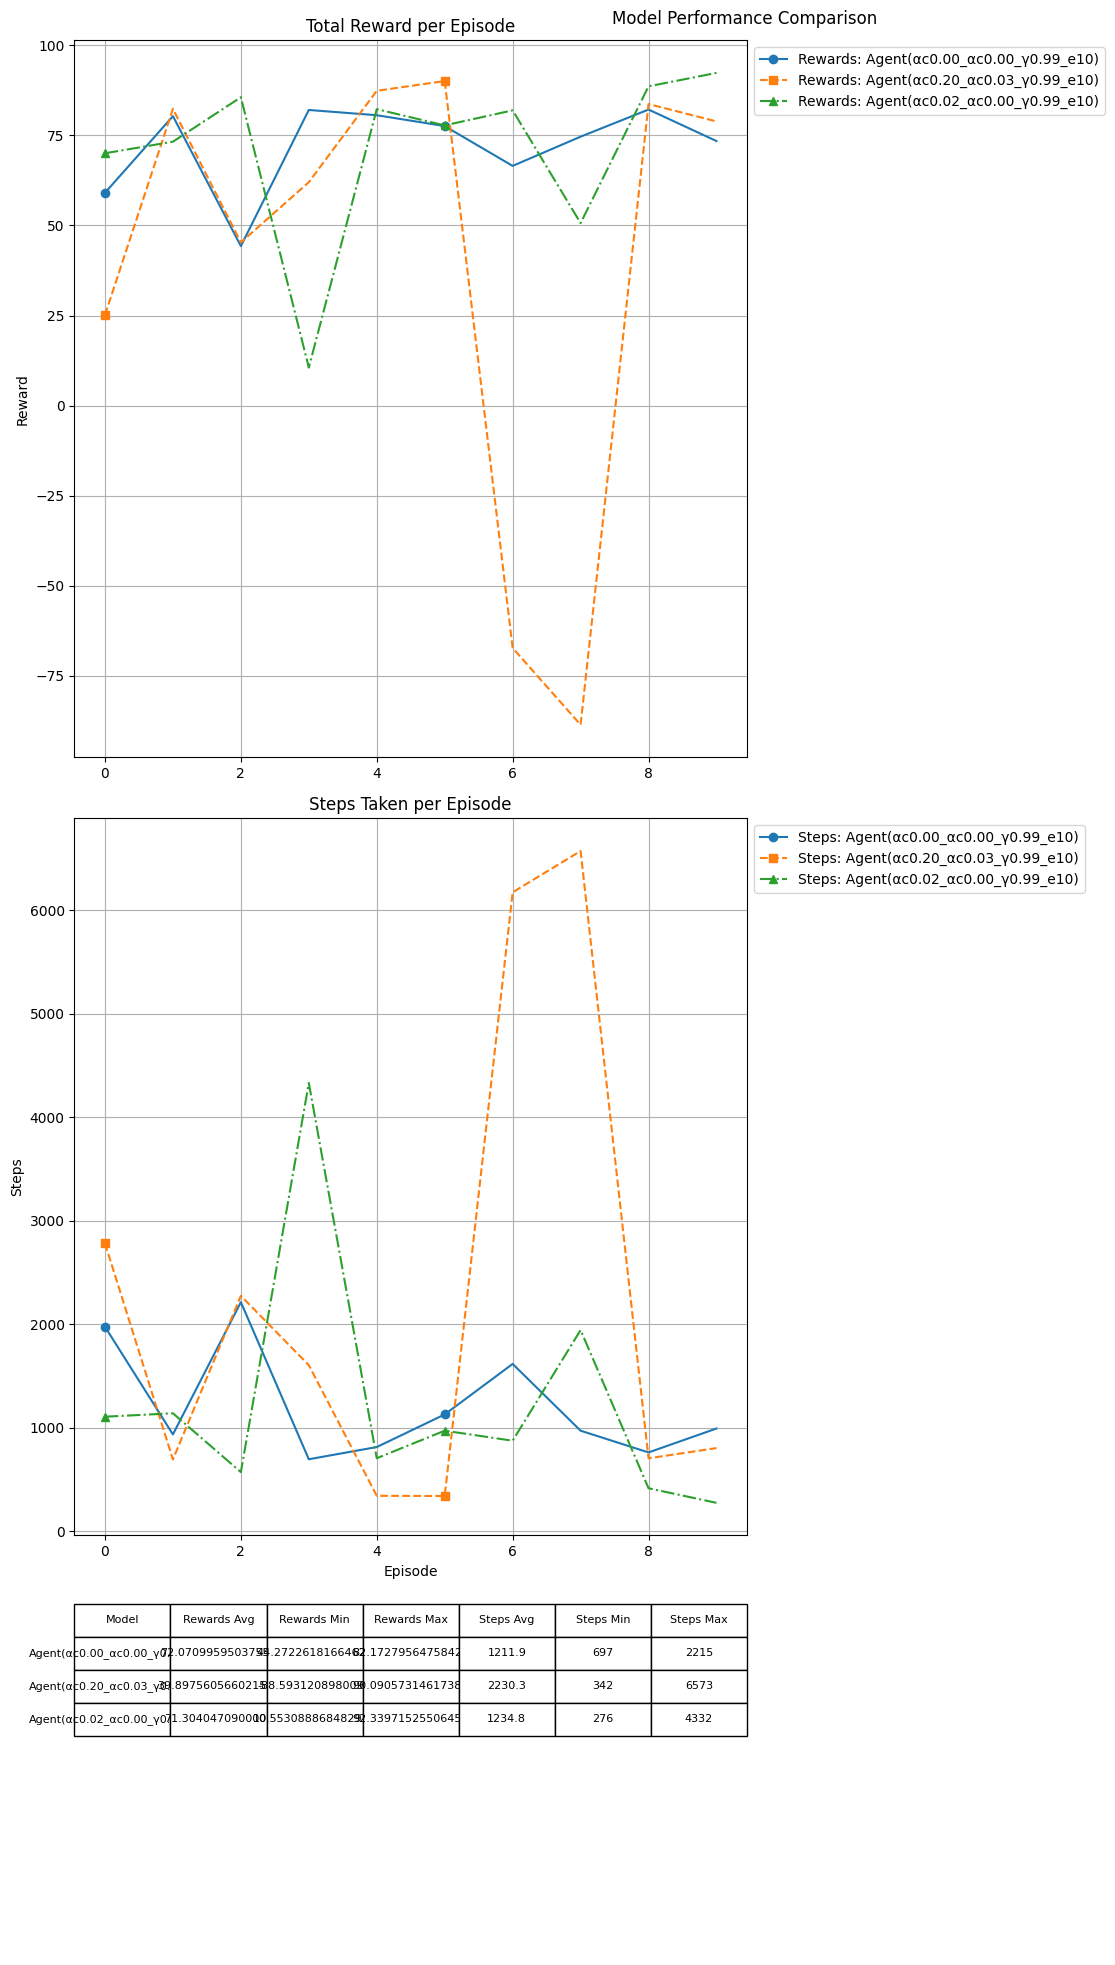

Ranked Models by Max Reward:
1. Agent(αc0.02_αc0.00_γ0.99_e10): Max Reward = 92.33971525506459
2. Agent(αc0.20_αc0.03_γ0.99_e10): Max Reward = 90.09057314617382
3. Agent(αc0.00_αc0.00_γ0.99_e10): Max Reward = 82.17279564758421


In [50]:
models = [agenta, agentb, agentc]

comparator = ModelComparator(models)
comparator.report()
comparator.rank()

In [ ]:
# run the best model
agenta.run()